### Light Cleaning of Tweet Data with BERT

Here, we test keeping in a lot of contextual words within the Tweet, such as stopwords, punctuation, and other indicators. We don't lemmatize or stem as well.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn import feature_extraction, preprocessing, linear_model, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from pandas_profiling import ProfileReport
import string
import random
import re
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
import transformers
from transformers import BertModel, BertTokenizer, TFBertModel, TFBertForSequenceClassification, BertConfig, AdamW, get_linear_schedule_with_warmup
import torch
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, Conv1D, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bert
import sys
import os
sys.path.append('../utility')
import utils

# seaborn settings
sns.set_theme(style="whitegrid")
np.random.seed(1)
torch.manual_seed(1)

In [2]:
# download pickles
train_df = pd.read_pickle("../data/pickles/clean_train_data.pkl")
test_df = pd.read_pickle("../data/pickles/clean_test_data.pkl")

### Light Text Cleaning

We need to make sure the tweets we are using in our dataset are at least readable like sentences, without too many odd punctuation etc.

In [3]:
# function taken and modified 
# from https://towardsdatascience.com/cleaning-text-data-with-python-b69b47b97b76

def simple_text_clean(x):
    # first we lowercase everything
    x = x.lower()
    # remove unicode characters
    x = x.encode('ascii', 'ignore').decode()
    x = re.sub(r'https*\S+', ' ', x)
    x = re.sub(r'http*\S+', ' ', x)
    # then use regex to remove @ symbols and hashtags
    #x = re.sub(r'@\S', '', x)
    #x = re.sub(r'#\S+', ' ', x)
    x = re.sub(r'\'\w+', '', x)
    #x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
    x = re.sub(r'\w*\d+\w*', '', x)
    x = re.sub(r'\s{2,}', ' ', x)
    x = re.sub(r'\s[^\w\s]\s', '', x)
    return x

In [4]:
train_df['cleaned_text'] = train_df.text.apply(simple_text_clean)
test_df['cleaned_text'] = test_df.text.apply(simple_text_clean)

In [5]:
list(train_df['cleaned_text'].sample(20))

['all you have to do is look up sports riots on google and you see more than couches being burned.. you fr gotta go ',
 'this night just blew up rq',
 "disaster averted: police kill gunman with device' at cinema ",
 'the hurricane mixxtail kinda tastes like the watermelon four loko. ???????? @',
 '@kirafrog @mount_wario did you get wrecked again?',
 '[withering] to death. is an album found when he [undermine]d his backyard because his cat [inundated] the floor [mustering] cat food.',
 'our big baby climbed up on this thing on wheels-(io hawk)!his knee injury!!!!! where my belt?mr srk cook ur beautiful ass for punishment!',
 'mourning notices for stabbing arson victims stir politics of grief in israel ',
 'family mourns drowning oftoddler with rare epilepsy: bradley diebold suffered hundreds of epileptic_ ',
 '@crazyindapegcompletely understandable considering the trauma #ptsdchat',
 '#news #science london warship exploded in because sailors were recycling artillery cartridges... #life 

### Tokenization

I perform tokenization here as a basic way of including the data of my text into the machine learning model.

Tokenization separates a piece of text into tokens. These tokens are words. It allows the text data to be turned into numbers that the machine learning model can read.

**Separating text and non-text columns for tokenization:**

In [9]:
# create final dfs without text col
final_train_df = train_df.drop(columns=['text', 'id'])
final_test_df = test_df.drop(columns=['text', 'id'])

In [10]:
# save labels
train_labels = final_train_df['target']

In [11]:
# separate clean text
train_text = final_train_df['cleaned_text']
test_text = final_test_df['cleaned_text']

**For `cleaned_text` column, we tokenise using BertTokenizer:**

In [12]:
# we use a pre-trained bert model to tokenize the text
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

To start with, because BERT works with fixed-length sequences, we need to choose the maximum length of the sequences to best represent the model. By storing the length of each Tweet, we can do this and evaluate the coverage.

In [13]:
token_lens = []
for txt in list(train_text):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

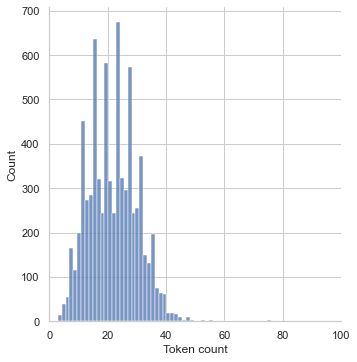

In [14]:
sns.displot(token_lens)
plt.xlim([0, 100])
plt.xlabel('Token count')
plt.show()

From this plot, we see the density drops off beyond 50. To be safe, we se the max length to 55.

In [20]:
def bert_tokenizer(text):
    encoding = tokenizer.encode_plus(
    text,
    max_length=55,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',  # Return PyTorch tensors
    )
    return encoding['input_ids'][0], encoding['attention_mask'][0]

In [21]:
max_length=55
# train data tokenization
train_tokenized_list = []
train_attn_mask_list = []
for text in list(train_text):
    tokenized_text, attn_mask = bert_tokenizer(text)
    train_tokenized_list.append(tokenized_text.numpy())
    train_attn_mask_list.append(attn_mask.numpy())

In [22]:
# test data tokenization
test_tokenized_list = []
test_attn_mask_list = []
for text in list(test_text):
    tokenized_text, attn_mask = bert_tokenizer(text)
    test_tokenized_list.append(tokenized_text.numpy())
    test_attn_mask_list.append(attn_mask.numpy())

In [23]:
train_tokenised_text_df = pd.DataFrame(train_tokenized_list)
test_tokenised_text_df = pd.DataFrame(test_tokenized_list)

In [24]:
# train test split
X_train, X_test, y_train, y_test, train_mask, test_mask = train_test_split(train_tokenised_text_df, train_labels, train_attn_mask_list, test_size=0.3, random_state=42)

In [25]:
print(f'X_train input shape {X_train.shape} X_test input shape {X_test.shape}\nTrain label \
shape {y_train.shape} Test label shape {y_test.shape}')

X_train input shape (5212, 55) X_test input shape (2235, 55)
Train label shape (5212,) Test label shape (2235,)


### BERT Modelling

We use a pretrained BERT model here. This is for efficiency.

In [26]:
num_classes = len(train_labels.unique())

In [31]:
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

checkpoint_path = "../models/light_tf_bert.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

print('\nBert Model', bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_75 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


After testing the model on 10 epochs (which took a long time), it was shown to overfit after the second epoch. Thus, the number of epochs is restricted to 2 as a measure of early stopping.

In [32]:
history=bert_model.fit(X_train,
                       y_train,
                       batch_size=32,
                       epochs=2,
                       validation_data=(X_test, y_test),
                       callbacks=[model_callback])

Epoch 1/4
163/163 [==============================] - 854s 5s/step - loss: 0.5444 - accuracy: 0.7228 - val_loss: 0.3860 - val_accuracy: 0.8345
Epoch 2/4
163/163 [==============================] - 860s 5s/step - loss: 0.3634 - accuracy: 0.8625 - val_loss: 0.3941 - val_accuracy: 0.8318
Epoch 3/4
163/163 [==============================] - 880s 5s/step - loss: 0.2819 - accuracy: 0.8970 - val_loss: 0.4363 - val_accuracy: 0.8081
Epoch 4/4
163/163 [==============================] - 818s 5s/step - loss: 0.2034 - accuracy: 0.9330 - val_loss: 0.5997 - val_accuracy: 0.7852


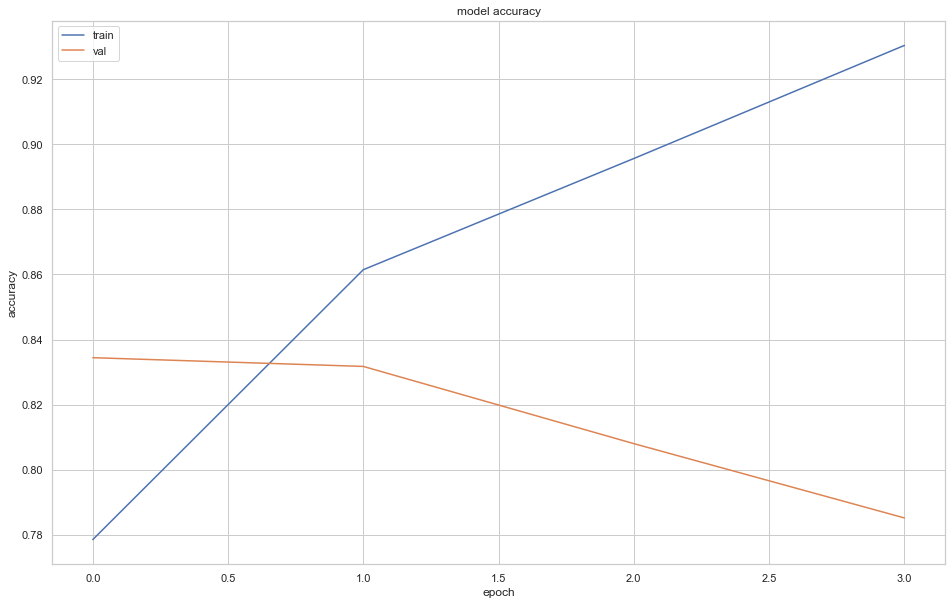

In [37]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

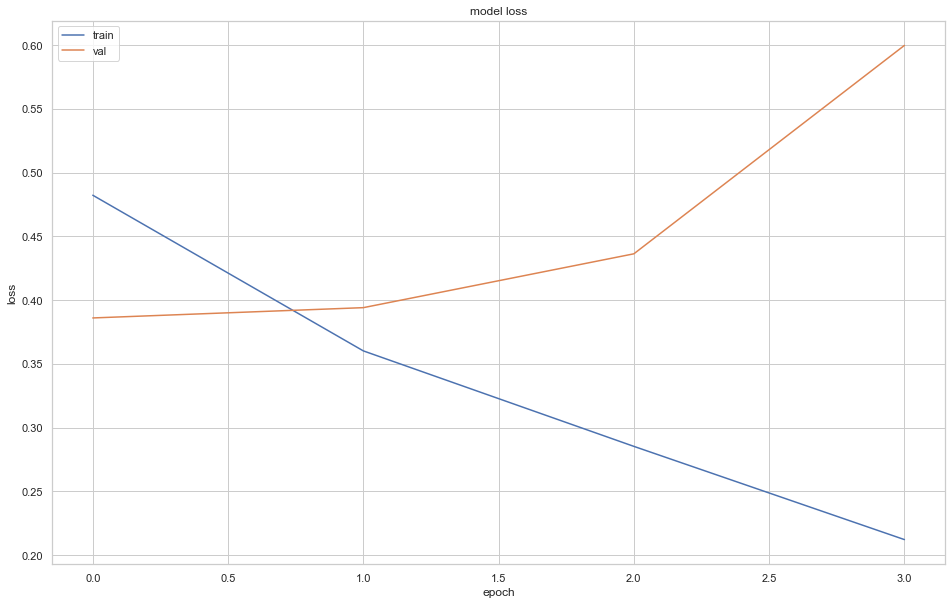

In [38]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
### if you want to access the model without retraining
# checkpoint_path = "../models/light_tf_bert.ckpt"
# trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
# trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

In [41]:
# predictions
test_pred = bert_model.predict(X_test)
print(test_pred)

TFSequenceClassifierOutput(loss=None, logits=array([[ 0.9218707, -0.6977585],
       [-2.2679389,  2.9030554],
       [-2.1937144,  2.7514935],
       ...,
       [-1.8326094,  2.6504776],
       [ 1.3864447, -1.6284075],
       [-0.7670491,  1.7233028]], dtype=float32), hidden_states=None, attentions=None)


In [42]:
tensor_test_predictions = tf.math.softmax(test_pred.logits, axis=1)
print(tensor_test_predictions)

tf.Tensor(
[[0.83474404 0.16525604]
 [0.00564685 0.9943532 ]
 [0.00706714 0.9929329 ]
 ...
 [0.01117225 0.9888277 ]
 [0.95324063 0.0467594 ]
 [0.07653733 0.92346275]], shape=(2235, 2), dtype=float32)


In [43]:
test_predictions = [list(bert_model.config.id2label.keys())[i] for i in tf.math.argmax(tensor_test_predictions, axis=1).numpy()]

In [44]:
# model test function
def eval_model(predictions):
    print(accuracy_score(y_test, predictions))
    # Compute fpr, tpr, thresholds and roc auc
    fpr, tpr, thresholds = roc_curve(np.array(y_test), np.array(predictions))
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    print(classification_report(y_test, np.array(predictions), target_names=["not disaster", "disaster"]))

0.785234899328859


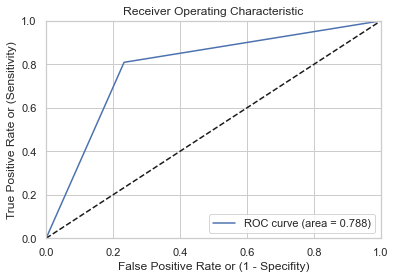

              precision    recall  f1-score   support

not disaster       0.84      0.77      0.80      1271
    disaster       0.72      0.81      0.76       964

    accuracy                           0.79      2235
   macro avg       0.78      0.79      0.78      2235
weighted avg       0.79      0.79      0.79      2235



In [45]:
eval_model(test_predictions)

In [46]:
# actual test predictions
real_pred = bert_model.predict(test_tokenised_text_df)
print(real_pred)

TFSequenceClassifierOutput(loss=None, logits=array([[-2.1371632,  2.688756 ],
       [-2.0297184,  2.6197913],
       [-2.0603564,  2.676914 ],
       ...,
       [-2.1950448,  2.819219 ],
       [-1.083955 ,  1.9225634],
       [-2.0043676,  2.7361658]], dtype=float32), hidden_states=None, attentions=None)


In [47]:
real_tensor_predictions = tf.math.softmax(real_pred.logits, axis=1)
print(real_tensor_predictions)

tf.Tensor(
[[0.00795538 0.99204457]
 [0.00947565 0.99052435]
 [0.00868642 0.99131364]
 ...
 [0.00659869 0.99340135]
 [0.04713226 0.9528677 ]
 [0.00865837 0.99134165]], shape=(3263, 2), dtype=float32)


In [228]:
# use argmax function to label
real_predictions = [list(bert_model.config.id2label.keys())[i] for i in tf.math.argmax(real_tensor_predictions, axis=1).numpy()]

### Preparing Kaggle Submission

All we need to do now is turn our output probabilities of our machine learning model into boolean values and submit the predictions!

In [ ]:
utils.kaggle_submit(real_predictions, 'submission4.csv')

To submit, we use the Kaggle API and type the following:

`kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Message"`